In [1]:
# chapter2 : Local Image Descriptors

In [2]:
#2.1 Harris corner detector - It basically finds the difference in intensity for a displacement of 
#(u,v) in all directions

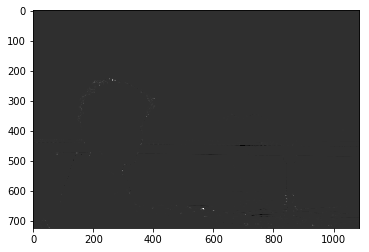

In [155]:
#using Opencv harris corner detector
import cv2
import matplotlib.pyplot as plt
import numpy as np
filename = "thumb_DSC_0363_1024.jpg"
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(dst)
plt.show()
#cv2.imshow('dst',img)

In [156]:
#using PIL, numpy and scipy for different values sigma and specific values of determinant and trace 
import sys
from PIL import Image
from numpy import *
from pylab import *
from scipy.ndimage import filters
def compute_harris_response(im,sigma):
    """ Compute the Harris corner detector response function
    for each pixel in a graylevel image. """
    # derivatives
    imx = zeros(im.shape)
    filters.gaussian_filter(im, sigma, (0,1), imx)
    print len(imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, sigma, (1,0), imy)
    # compute components of the Harris matrix
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)
    # determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet/Wtr

In [157]:
def get_harris_points(harrisim,min_dist,threshold=0.5):
    """ Return corners from a Harris response image
    min_dist is the minimum number of pixels separating
    corners and image boundary. """
    # find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    # get coordinates of candidates
    coords = array(harrisim_t.nonzero()).T # ...and their values
    candidate_values = [harrisim[c[0],c[1]] for c in coords] # sort candidates
    index = argsort(candidate_values)
    # store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    # select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                              (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    return filtered_coords

In [158]:
#fil_cord = get_harris_points(Wtr,min_dist=10,threshold=0.1)


In [159]:
def plot_harris_points(image,filtered_coords):
    """ Plots corners found in image. """
    figure()
    gray()
    imshow(image)
    plot([p[1]for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    axis('off')
    show()

724


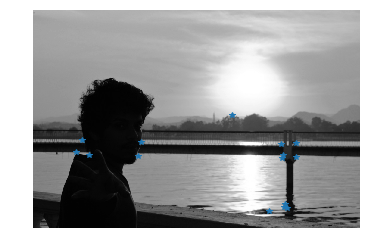

In [160]:
im = array(Image.open('thumb_DSC_0363_1024.jpg').convert('L'))
harrisim = compute_harris_response(im,4)
filtered_coords = get_harris_points(harrisim,10)
plot_harris_points(im, filtered_coords)

In [161]:
def get_descriptors(image,filtered_coords,wid=5):
    """ For each point return pixel values around the point
    using a neighbourhood of width 2*wid+1. (Assume points are
    extracted with min_distance > wid). """
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1, coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    return desc
def match(desc1,desc2,threshold=0.5):
    """ For each corner point descriptor in the first image,
    select its match to second image using
    normalized cross correlation. """
    n = len(desc1[0])
    # pair-wise distances
    d = -ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value
    ndx = argsort(-d)
    matchscores = ndx[:,0]
    return matchscores

In [162]:
def match_twosided(desc1,desc2,threshold=0.5): 
    """ Two-sided symmetric version of match(). """
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    ndx_12 = where(matches_12 >= 0)[0]
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12

In [163]:
def appendimages(im1,im2):
    """ Return a new image that appends the two images side-by-side. """
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # if none of these cases they are equal, no filling needed.
    return concatenate((im1,im2), axis=1)

def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True): 
    """ Show a figure with lines joining the accepted matches
    input: im1,im2 (images as arrays), locs1,locs2 (feature locations), matchscores (as output from ’match()’),
    show_below (if images should be shown below matches). """
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    imshow(im3)
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    axis('off')

279
724
starting matching


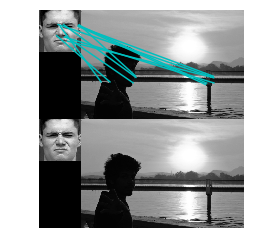

In [241]:
wid = 5
im1 = array(Image.open("S107_005_00000011.png").convert("L"))
harrisim = compute_harris_response(im1,5)
filtered_coords1 = get_harris_points(harrisim,wid+1)
d1 = get_descriptors(im1,filtered_coords1,wid)

im2 = array(Image.open("thumb_DSC_0363_1024.jpg").convert("L"))
harrisim = compute_harris_response(im2,5)
filtered_coords2 = get_harris_points(harrisim,wid+1)
d2 = get_descriptors(im2,filtered_coords2,wid)
print 'starting matching'
matches = match_twosided(d1,d2)
figure()
plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)
show()

In [170]:
#2.2 SIFT - Scale-Invariant Feature Transform

In [242]:
#using Cv2 .. refer book for a better understanding of the algo and implimentation 
import cv2
import numpy as np
def cal_sift(img):
    img = cv2.imread('PF.png')
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imwrite('sift_keypoints.jpg',img)
    return kp,des

In [243]:
def match(desc1,desc2):
    """ For each descriptor in the first image,
    select its match in the second image.
    input: desc1 (descriptors for the first image),
    desc2 (same for second image). """
    desc1 = array([d/linalg.norm(d)for d in desc1])
    desc2 = array([d/linalg.norm(d) for d in desc2])
    dist_ratio = 0.6
    desc1_size = desc1.shape
    matchscores = zeros((desc1_size[0],1),'int')
    desc2t = desc2.T # precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = argsort(arccos(dotprods))
        # check if nearest neighbor has angle less than dist_ratio times 2nd
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]: matchscores[i] = int(indx[0])
    return matchscores

In [244]:
im2 = array(Image.open("thumb_DSC_0363_1024.jpg").convert("L"))
im1 = array(Image.open("S107_005_00000011.png").convert("L"))
kp,des = cal_sift(im1)
kp1,des1 = cal_sift(im2)

In [245]:
#Feature Matching 

In [246]:
#Brute-Force Matching with ORB Descriptors
import numpy as np
import cv2
import matplotlib.pyplot as plt
img1 = cv2.imread("IMG_0206.JPG",0)          # queryImage
img2 = cv2.imread("IMG_0207.JPG",0) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

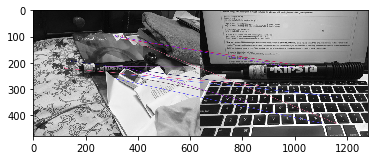

(<matplotlib.image.AxesImage at 0x11361a4d0>, None)

In [248]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2)
plt.imshow(img3),plt.show()


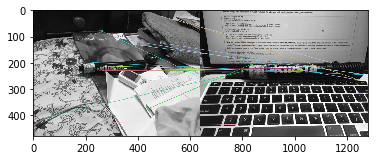

(<matplotlib.image.AxesImage at 0x1196c34d0>, None)

In [250]:
#Brute-Force Matching with SIFT Descriptors and Ratio Test
import numpy as np
import cv2
from matplotlib import pyplot as plt
img1 = cv2.imread("IMG_0206.JPG",0)          # queryImage
img2 = cv2.imread("IMG_0207.JPG",0)
# trainImage
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
plt.imshow(img3),plt.show()

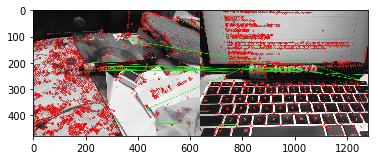

(<matplotlib.image.AxesImage at 0x113cd2a50>, None)

In [251]:
#FLANN based Matcher
import numpy as np
import cv2
from matplotlib import pyplot as plt
img1 = cv2.imread("IMG_0206.JPG",0)          # queryImage
img2 = cv2.imread("IMG_0207.JPG",0)
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()